In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

### Gathering the Data

[*********************100%***********************]  1 of 1 completed


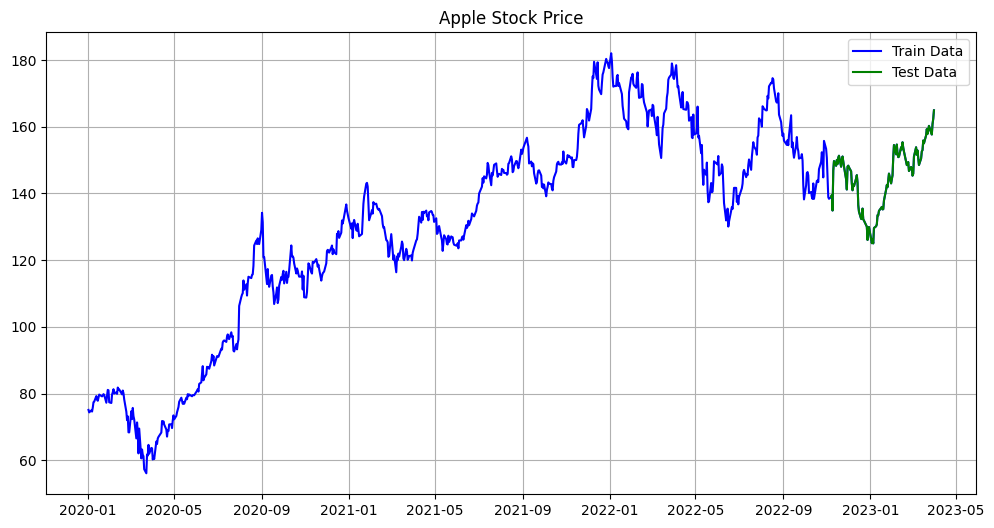

In [3]:
data = yf.download('AAPL', start='2020-01-01', end='2023-04-01')['Close']

plt.figure(figsize=(12, 6))
plt.plot(data.index, data, color='blue', label='Train Data')
plt.plot(data.index[-100:], data[-100:], color='green', label='Test Data')
plt.legend()
plt.grid()
plt.title('Apple Stock Price')
plt.show()

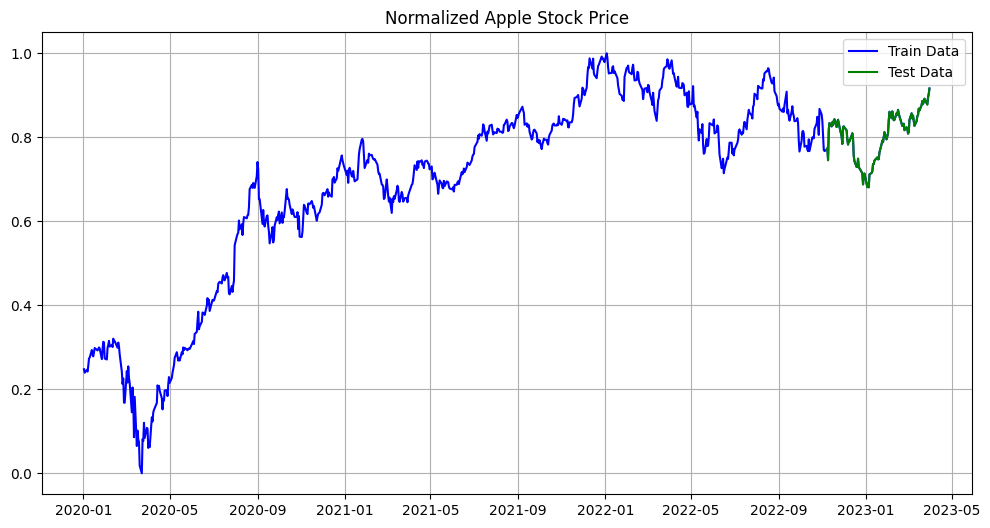

In [6]:
# Normalize the data to solve the extrapolation problem

scaler = MinMaxScaler(feature_range=(0, 1))
log_data = np.log(data.values)
norm_data = scaler.fit_transform(log_data.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(data.index, norm_data, color='blue', label='Train Data')
plt.plot(data.index[-100:], norm_data[-100:], color='green', label='Test Data')
plt.grid()
plt.legend()
plt.title('Normalized Apple Stock Price')
plt.show()

In [7]:
train_data = norm_data[:-100]
test_data = norm_data[-100:]

In [128]:
# Modify the transition matrix to model acceleration (trend, velocity, and acceleration)
F = np.array([[1, 1, 0.5],  # Trend depends on previous trend, velocity, and acceleration
              [0, 1, 1],    # Velocity depends on previous velocity and acceleration
              [0, 0, 1]])   # Acceleration remains constant

# Modify the observation matrix (we only observe trend)
H = np.array([[1, 0, 0]])   # We observe only the trend (stock price)

# Initialize Kalman Filter with an additional state for acceleration
kf = KalmanFilter(
    transition_matrices = F,
    observation_matrices = H,
    initial_state_mean = [train_data.reshape(-1)[0], 0, 0],  # Initial trend, velocity, and acceleration
    initial_state_covariance = np.eye(3),        # Covariance for all 3 states
    observation_covariance = np.array([[2]]),    # Observation noise
    transition_covariance = np.eye(3) * 0.5      # Process noise to allow state change
)

# Apply smoothing or filtering
state_means_smooth, _ = kf.smooth(train_data)


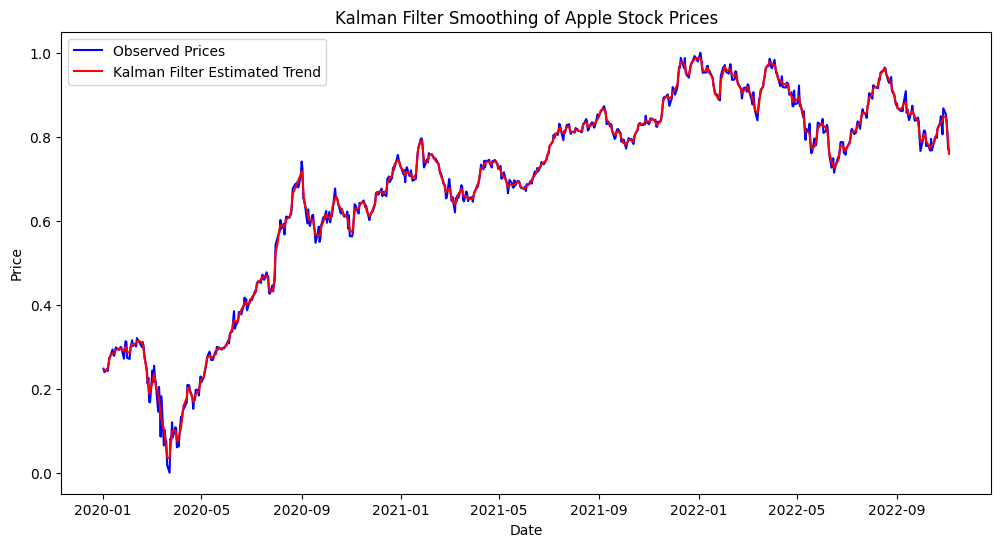

In [129]:
# Extract the estimated trend (first component of state means)
estimated_trend = state_means_smooth[:, 0]

# Plot the original noisy prices and the estimated trend
plt.figure(figsize=(12, 6))
plt.plot(data.index[:-100], train_data, label="Observed Prices", color='blue')
plt.plot(data.index[:-100], estimated_trend, label="Kalman Filter Estimated Trend", color='red')
plt.title('Kalman Filter Smoothing of Apple Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [125]:
# Predict the next 5 days (or however many steps) of stock prices
n_steps = 5
state_means_forecast, _ = kf.filter(test_data)
state_means_forecast, state_cov_forecast = kf.smooth(test_data)

# Get the last estimated state (both trend and velocity)
predicted_state = state_means_forecast[-1, :]  # Last state [price, velocity]

predicted_trend = []

# Predict n_steps into the future using the Kalman Filter transition matrix
for i in range(n_steps):
    # Propagate the state using the transition matrix (use matrix multiplication)
    predicted_state = np.dot(F, predicted_state)
    predicted_trend.append(predicted_state[0])  # Append the predicted trend (price)

# Create a date index for the next n_steps into the future
forecast_index = pd.date_range(start=data.index[-100] + pd.Timedelta(days=1), periods=n_steps)

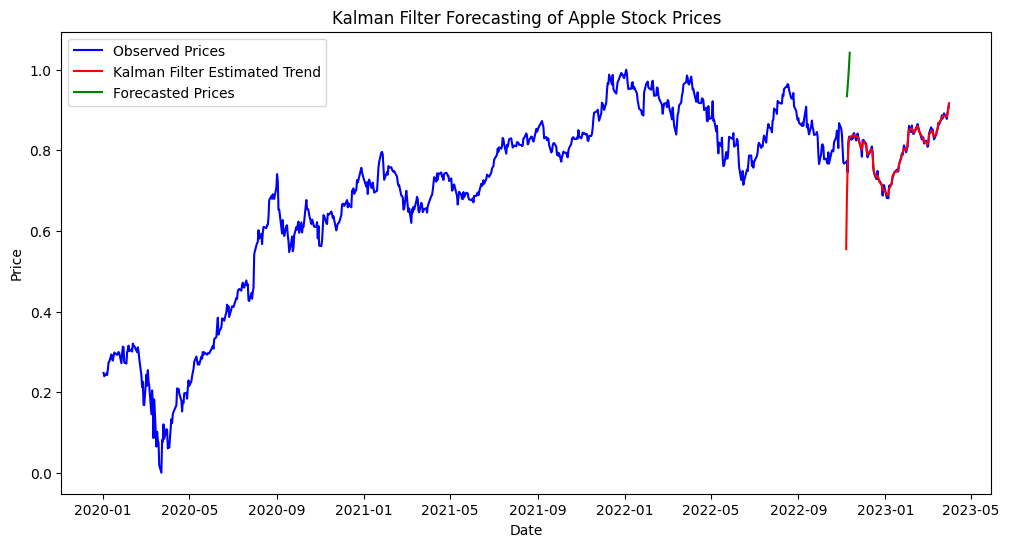

In [126]:
# Plot the observed prices, estimated trend, and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(data.index, norm_data, label='Observed Prices', color='blue')
plt.plot(data.index[-100:], state_means_forecast[:, 0], label='Kalman Filter Estimated Trend', color='red')
plt.plot(forecast_index, predicted_trend, label='Forecasted Prices', color='green')
plt.title('Kalman Filter Forecasting of Apple Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


The results are poorly because stock data is highly non-linear, so to model it we needed more dimensions

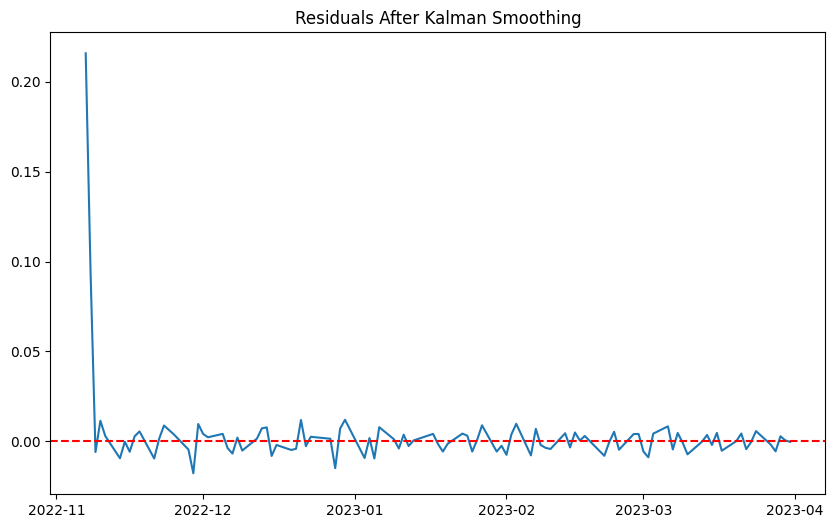

In [127]:
# Calculate the residuals (difference between observed prices and the estimated trend)
residuals = test_data.reshape(-1) - state_means_forecast[:, 0]

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.plot(data.index[-100:], residuals, label='Residuals')
plt.title('Residuals After Kalman Smoothing')
plt.axhline(0, color='red', linestyle='--')
plt.show()
